# Lecture-10 Build a neural network from sractch

## Target: using python and numpy implement a neural network framework.

> Node:
+ forward: *Function*, how to calculate the inputs
+ backwards: *Function*, how to get the gradients when backpropogation
+ gradients: *Mapper*, the gradient map the this node of its inputs node
+ inputs: *List*, the input nodes of this node
+ outputs: *List*, the output node of this node
 

## 面向对象的方式来组织这个

In [1]:
def add(a, b):
    return a + b

In [2]:
var_int = 10
var_2_int = 20

In [3]:
add(var_int, var_2_int)

30

In [4]:
var_int = [100, 200] # 如果在C/Java里边，这句话根本就不能通过编译
var_2_int = [122, 122233, 1231]

In [5]:
add(var_int, var_2_int)

[100, 200, 122, 122233, 1231]

## Confusing -> 读你代码的人很困惑，当时间过去。。。，你自己也看不懂了

## 构建基类

In [6]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs 
        of this is its successors. 
        
        and the value is *ax + b*
        """
        self.inputs = inputs # input_list <- C, Java <- 匈牙利命名法 -> Python 特别不建议
       # self.outputs = outputs # output_list 
        self.value = None 
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:
            node.outputs.append(self) # build a connection relationship
    
    def forward(self):
        """Forward propogation
        
        compute the output value based on input nodes and store the value 
        into *self.value*
        """
        raise NotImplemented
    
    def backward(self):
        """ Back propogation
        
        compute the gradient of each input node and store the value 
        into "self.gredients"
        """
        raise NotImplemented

In [7]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name= name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [8]:
import numpy as np

In [9]:
X = np.array([1, 2, 3])

In [10]:
W = np.array([[1, 2], [2, 4], [3, 5]])

In [11]:
X.shape

(3,)

In [12]:
W.shape

(3, 2)

In [13]:
B = np.array([1, 3])

In [14]:
np.dot(X, W) + B

array([15, 28])

In [15]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
    
    def forward(self): 
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    
    def backward(self):
        
        for node in self.outputs:
            #gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)
    

In [16]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node
    
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.x_node] = grad_cost * self.partial

In [17]:
W1 = np.array([[1, 1], [1, 2], [1, 3]])
W2 = np.array([[1, 1], [0, 2], [1, 4]])

In [18]:
(W1.reshape(-1, 1) - W2.reshape(-1, 1)) ** 2

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [19]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])
    
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        
        self.diff = y_true_flatten - y_hat_flatten
        
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] =  (-2 / n) * self.diff

In [20]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [21]:
def topological_sort(data_with_value):
    feed_dict = data_with_value 
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [22]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [23]:
from sklearn.datasets import load_boston

In [24]:
data = load_boston()

In [25]:
data

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [26]:
X_ = data['data']

In [27]:
X_.shape

(506, 13)

In [28]:
X

array([1, 2, 3])

In [29]:
y_ = data['target']

In [30]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [31]:
y_[0]

24.0

In [32]:
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [33]:
X_.shape[1]

13

In [34]:
n_features = X_.shape[1]

In [35]:
n_hidden = 10

In [36]:
n_hidden_2 = 10

In [37]:
X.shape

(3,)

In [38]:
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)

In [39]:
W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)

In [40]:
#W3, b3 = np.random.randn(n_hidden_2, 1), np.zeros(1)

## Build a graph connection 

### 1st. Build Nodes in this graph

In [41]:
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder

In [42]:
X.name,X.value,X.inputs,X.backward(),X.forward(),X.outputs,X.gradients

('X', None, [], None, None, [], {})

In [43]:
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')
#W3, b3 = Input(name='W3'), Input(name='b3')

### 2nd build connection relationship

In [44]:
linear_output = Linear(X, W1, b1)

In [45]:
linear_output

In [47]:
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

## 我们可以把它的网络变得更复杂

In [54]:
input_node_with_value = {  # -> feed_dict 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_，
}

SyntaxError: invalid character in identifier (<ipython-input-54-fb6855b14b25>, line 7)

In [52]:
graph = topological_sort(input_node_with_value)

In [53]:
graph

[Input Node: b1,
 Input Node: X,
 Input Node: y,
 Input Node: W2,
 Input Node: W1,
 Input Node: b2,

In [37]:
from sklearn.utils import resample

In [38]:
np.random.choice(range(100), size=10, replace=True)

array([54, 83,  0, 36, 96, 49,  5, 30, 26, 44])

In [81]:
def run(dictionary):
    return topological_sort(dictionary)

In [39]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size


for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        #indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
#         input_node_with_value = {  # -> feed_dict 
#             X: X_batch, 
#             y: y_batch, 
#             W1: W1.value, 
#             W2: W2.value, 
#             b1: b1.value, 
#             b2: b2.value,
#         }
        
#         graph = topological_sort(input_node_with_value)
        
        training_one_batch(graph)
        
        learning_rate = 1e-3
        
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 563.881
Epoch: 101, loss = 31.737
Epoch: 201, loss = 24.065
Epoch: 301, loss = 17.052
Epoch: 401, loss = 18.704
Epoch: 501, loss = 14.086
Epoch: 601, loss = 14.777
Epoch: 701, loss = 9.710
Epoch: 801, loss = 13.053
Epoch: 901, loss = 10.733
Epoch: 1001, loss = 10.266
Epoch: 1101, loss = 8.593
Epoch: 1201, loss = 12.082
Epoch: 1301, loss = 9.392
Epoch: 1401, loss = 10.868
Epoch: 1501, loss = 8.753
Epoch: 1601, loss = 9.349
Epoch: 1701, loss = 8.978
Epoch: 1801, loss = 9.155
Epoch: 1901, loss = 9.345
Epoch: 2001, loss = 5.828
Epoch: 2101, loss = 7.654
Epoch: 2201, loss = 8.030
Epoch: 2301, loss = 7.145
Epoch: 2401, loss = 9.038
Epoch: 2501, loss = 6.683
Epoch: 2601, loss = 6.978
Epoch: 2701, loss = 9.414
Epoch: 2801, loss = 7.571
Epoch: 2901, loss = 7.295
Epoch: 3001, loss = 8.166
Epoch: 3101, loss = 7.704
Epoch: 3201, loss = 7.409
Epoch: 3301, loss = 6.839
Epoch: 3401, loss = 7.359
Epoch: 3501, loss = 7.414
Epoch: 3601, loss = 7.873
Epoch: 3701, loss = 7.309
Epoch: 3801

In [40]:
import matplotlib.pyplot as plt

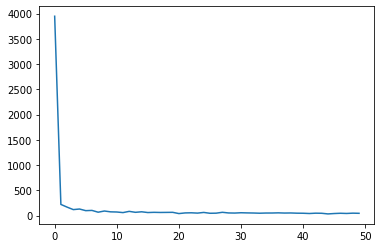

In [41]:
plt.plot(losses)

In [42]:
W1.value

array([[ 3.60741510e-01,  1.11401149e-01, -3.06979032e-04,
        -7.86237206e-01, -1.49408440e+00, -8.85535354e-01,
        -4.01728595e-01, -1.58128695e+00, -4.60439357e-01,
         1.94271851e+00],
       [ 3.33136371e-01,  9.25937327e-01,  7.95694235e-01,
         7.77624499e-01, -1.39947425e-01,  3.85324719e-01,
        -8.54638597e-01,  1.13236813e-01, -1.60978798e-03,
        -5.83018279e-03],
       [-8.45886274e-01,  1.40430776e+00, -2.51747921e-01,
        -1.20016953e+00, -4.31374015e-01,  6.69968875e-01,
        -8.24136017e-01,  1.27798448e+00, -4.18227857e-01,
         1.91650480e-01],
       [ 3.86069338e-02, -3.25460527e-01,  1.47650793e-01,
        -1.06568200e-01, -2.24340613e-02, -2.47089102e-01,
        -8.99908155e-01,  3.87418988e+00, -5.42950175e-02,
        -1.25986186e-01],
       [ 8.33261702e-01,  1.71688649e+00, -1.13789304e+00,
        -3.59402924e-01, -3.68466301e+00,  1.83600320e+00,
         4.29844897e-01,  6.88457908e-01, -1.10028018e+00,
        -5.

In [43]:
W2.value

array([[0.49665464],
       [4.090967  ],
       [9.11905852],
       [6.20908378],
       [6.98682666],
       [4.0722051 ],
       [5.02766168],
       [6.28976326],
       [4.28701438],
       [6.11779997]])

In [44]:
X_[1]

array([-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
        0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
       -0.30309415,  0.44105193, -0.49243937])

linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

In [45]:
x1 = Input()

In [46]:
x1.value = X_[1]

In [47]:
y_of_x1 =  Linear(Sigmoid(Linear(x1, W1, b1)), W2, b2)

In [48]:
W1.value.shape

(13, 10)

In [49]:
 def _sigmoid(x):
        return 1. / (1 + np.exp(-1 * x))

In [50]:
np.dot(_sigmoid(np.dot(X_[1], W1.value) + b1.value), W2.value) + b2.value

array([22.26931483])

In [51]:
y_[1]

21.6

In [52]:
y_of_x1